In [4]:
import torch
import pyro
import pyro.distributions as pdist
import torch.distributions as dist

pyro.set_rng_seed(101)

## Weather example

In [3]:
# all written in pytorch - independent of pyro
def weather():
    cloudy = dist.Bernoulli(0.3).sample()
    sky = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny':75.0}[sky]
    scale_temp = {'cloudy':10.0, 'sunny':15.0}[sky]
    temp = dist.Normal(mean_temp, scale_temp).rsample()
    return sky, temp.item()



## pyro primatives

In [6]:
# telling pyro which things to track - which means this now defines 
# a joint density p(temp, sky) over tempreture and sky.  
def weather():
    cloudy = pyro.sample('cloudy', pdist.Bernoulli(0.3))
    sky = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny':75.0}[sky]
    scale_temp = {'cloudy':10.0, 'sunny':15.0}[sky]
    temp = dist.Normal(mean_temp, scale_temp).rsample()
    return sky, temp.item()

for _ in range(3):
    print(weather())


('cloudy', 35.4540901184082)
('sunny', 83.63148498535156)
('sunny', 75.91869354248047)


## Higher-order stochastic functions and recursion

In [19]:
def ice_cream_sales():
    sky, temp = weather()
    expected_sales = 200. if sky == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pdist.Normal(expected_sales, 10.0))
    return ice_cream

## tail-recursion 

In [62]:
def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pdist.Bernoulli(p))
    if x.item() == 1:
        return 0
    else:
        return 1 + geometric(p, t + 1)


In [70]:
def normal_product(loc, scale):
    z1 = pyro.sample("z1", pyro.distributions.Normal(loc, scale))
    z2 = pyro.sample("z2", pyro.distributions.Normal(loc, scale))
    y = z1 * z2
    return y

def make_normal_normal():
    ''' returns a function '''
    mu_latent = pyro.sample("mu_latent", pyro.distributions.Normal(0, 1))
    fn = lambda scale: normal_product(mu_latent, scale)
    return fn

print(make_normal_normal()(2.6))

tensor(8.2429)


## Inference in pyro

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pyro.optim as opt


In [80]:
def scale(guess):
    weight_given_guess = pyro.sample('weight', pdist.Normal(guess,1))
    measurement_given_guess_and_weight = pyro.sample('measurement', pdist.Normal(weight_given_guess ,0.75))
    return measurement_given_guess_and_weight


In [110]:
# because conditioning behaves like an ordinary python function, 
# conditioning can be defrred or parameterized with python lambdas or defs
def deferred_conditioned_scale(measurement, guess):
    conditioned_scale = pyro.condition(scale,data={'measurement': measurement})(guess)
    return conditioned_scale

# you can pass observations to both sample and conditional statements. 

def scale_obs(guess, measurement):
    ''' equivelent deferred_conditioned_scale()'''
    weight_given_guess  = pyro.sample("weight", pdist.Normal(guess,1.))
    # now we condition on the measurement == 9.5
    return pyro.sample('measurement', pdist.Normal(weight_given_guess ,1),obs= measurement)

measurement = 35
guess = 3
con1 = deferred_conditioned_scale(measurement,guess)
con2 = scale_obs(guess,measurement)
assert con1 == con2, 'Conditionals are not defined correctly'

## Guide functions

Guides represent approximate posterior distributions

1. all unobserved (i.e., not conditioned) sample statements that appear in the model appear in the guide. "Raw samples"
2. the guide has the same input signature as the model (i.e., takes the same arguments)

In [120]:
# For the above problem we can analytically calculate the posterior as we have conjugate priors

def perfect_guide(guess):
    loc =(0.75**2 * guess + 9.5) / (1 + 0.75**2) # 9.14
    scale = np.sqrt(0.75**2/(1 + 0.75**2)) # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

# pyro.param is pyros library for storing the guide parameters. The optimizations should happen over those parameters. 


def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", pdist.Normal(a, torch.abs(b))) # as the stanard deviation must be positive ( in the case it alway will)

# we can re-write this using the built in constraints of the pytorch library. 

from torch.distributions import constraints
def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", pdist.Normal(a, b))



### Using SVI to perform parameter estimation in the guide program


a = 9.139286041259766
b = 0.5956957936286926


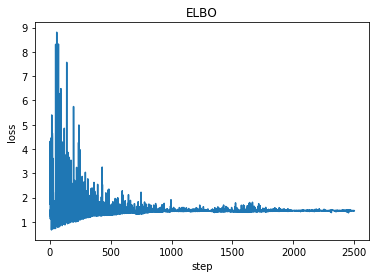

In [121]:
guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model =conditioned_scale,
                    guide = scale_parametrized_guide_constrained,
                    optim = opt.SGD({'lr':0.001,'momentum':0.1}),
                    loss =pyro.infer.Trace_ELBO())

losses, a, b = [], [] , []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param('a').item())
    b.append(pyro.param('b').item())

plt.plot(losses)
plt.title('ELBO')
plt.xlabel('step')
plt.ylabel('loss')
print('a = {}'.format(pyro.param('a').item()))
print('b = {}'.format(pyro.param('b').item()))

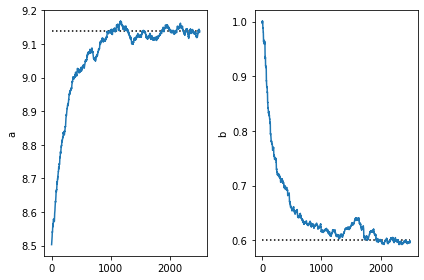

In [125]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()

# Stochastic Variational Inference 

In pyro the guide directly specifies the variational approximation. In all our experiments so far we had been using the Normal distribution and treating the mean and variance as unknown parameters to be learnt by the network. 

**Note**: The *guide* needs to provide a valid joint probability density over all the latent random variables in the model. 

That is for each latent that appears in the model, as a prior, it must also appear in the guide as a prior. 

```python
def model():    
    z1 = pyro.sample('z1', pdist.Normal(0,1))

def guide():
    z1 = pyro.sample('z1', ...) # the distribution here can be different to the model
    
```

## Defining the Objective

Typically we use the ELBO, which is dependent upon the KL-divergence. Different objectives do exist, see (Structured Disentangled Representations)[https://arxiv.org/pdf/1804.02086.pdf] for different objectives using KL. 

### Problem set-up

The user has to provide the following:
1. the model
2. the guide
3. an optimizer

When defining the optimizer, it must be ensured that the guide program does not contain any sample statements with observations. Not entirely sure that this means that you can't use condition statements. I should suspect that you still can, else you would not be able to do any form of conditional density estimation. 


### A simple example

In [ ]:
from pyro.infer import SVI, Trace_ELBO
import math
import os
pyro.enable_validation(True)

pyro.clear_param_store()

# Generate data
nHeads = 6
nTails = 4
data = []
for _ in range(nHeads):
    data.append(torch.tensor(1.0))
for _ in range(nTails):
    data.append(torch.tensor(0.0))

# Define program

def model(data):
    # define the hyperparameters that control the beta rior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    flip = pyro.sample('biasness', pdist.Beta(alpha0,beta0))
   
    # loop over observed data
    for i in range(len(data)):
        pyro.sample('obs_{}'.format(i), pdist.Bernoulli(flip), obs=data[i])

def guide(data):
    # register the two variational parameters with pyro
    alpha_q = pyro.param('alpha_q', torch.tensor(15.0),
                         constraint= constraints.positive)
    beta_q= pyro.param('beta_q',
                       torch.tensor(15.0), constraint= constraints.positive)
    
    pyro.sample('biasness', pdist.Beta(alpha_q, beta_q))

# Inference

lr = 0.0005
betas = (0.9,0.999)
def inference(lr, betas):
    adam_params = {'lr':lr, 'betas': betas}
    optimizer = opt.Adam(adam_params)

    svi = SVI(model=model, guide=guide, optim=optimizer, loss=Trace_ELBO() )

    nSteps = 5000

    for step in range(nSteps):
        svi.step(data)
        if step % 100 == 0:
            print('.', end='')
    return svi

# Inference results

svi = inference(lr,betas)

## learnt variational parameters
alpha_q = pyro.param('alpha_q').item()
beta_q = pyro.param('beta_q').item()

print('The learnt variational parameters are : alpha_q : {} and beta_q : {}'.format(alpha_q, beta_q))
## inferred quantities
inferred_mean = alpha_q / (alpha_q + beta_q) 
inferred_std= math.sqrt(alpha_q*beta_q / ((alpha_q + beta_q)**2 * (alpha_q + beta_q + 1)))



print("\n based on the data and our prior belief, the fairness of the coin is {} +- {}".format(inferred_mean, inferred_std))

.......................................